<a href="https://colab.research.google.com/github/U1186204/Explainable-Techniques/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI | Explainable Techniques

Description: This work evaluates Spotify customer churn into 3 major segments. First, it performs analysis as to which features might be correlated and impacful towards churn. Second, it implements a XG Boost model to predict church. Lastly, it employes 3 Explainable Techniques(PDP, ICE, ALE) to evaluate the model's feature performance in predicting Churn.  

*by Christian Moreira, Master's in Data Science @ Duke University*


[![Repo](https://img.shields.io/badge/GitHub-Explainable--Techniques-blue?logo=github)](https://github.com/U1186204/Explainable-Techniques)

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/U1186204/Explainable-Techniques/blob/main/main.ipynb)

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBClassifier
import shap
import lime
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
import warnings
warnings.filterwarnings('ignore')

### Importing Dataset from Kaggle

In [ ]:
path = kagglehub.dataset_download("nabihazahid/spotify-dataset-for-churn-analysis")
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

print("Path to dataset files:", path)
print(f"Dataset loaded successfully! Dimensions: {df.shape}")

Path to dataset files: C:\Users\chris\.cache\kagglehub\datasets\nabihazahid\spotify-dataset-for-churn-analysis\versions\2
Dataset loaded successfully! Dimensions: (8000, 12)


In [ ]:
# Print column name, datatype, and number of missing values
for column in df:
    print(f"{column}: {df[column].dtype}")

user_id: int64
gender: object
age: int64
country: object
subscription_type: object
listening_time: int64
songs_played_per_day: int64
skip_rate: float64
device_type: object
ads_listened_per_week: int64
offline_listening: int64
is_churned: int64


In [ ]:
print(df.sample(5))

      user_id  gender  age country subscription_type  listening_time  \
2733     2734   Other   20      FR           Premium             248   
6440     6441    Male   32      DE              Free              62   
3245     3246    Male   33      CA           Premium             134   
2877     2878  Female   53      US            Family              42   
1211     1212    Male   59      DE           Premium              51   

      songs_played_per_day  skip_rate device_type  ads_listened_per_week  \
2733                    67       0.40     Desktop                      0   
6440                    43       0.01     Desktop                     47   
3245                    34       0.04     Desktop                      0   
2877                     5       0.12         Web                      0   
1211                    30       0.03     Desktop                      0   

      offline_listening  is_churned  
2733                  1           1  
6440                  0           

### EDA: Correlation Matrix

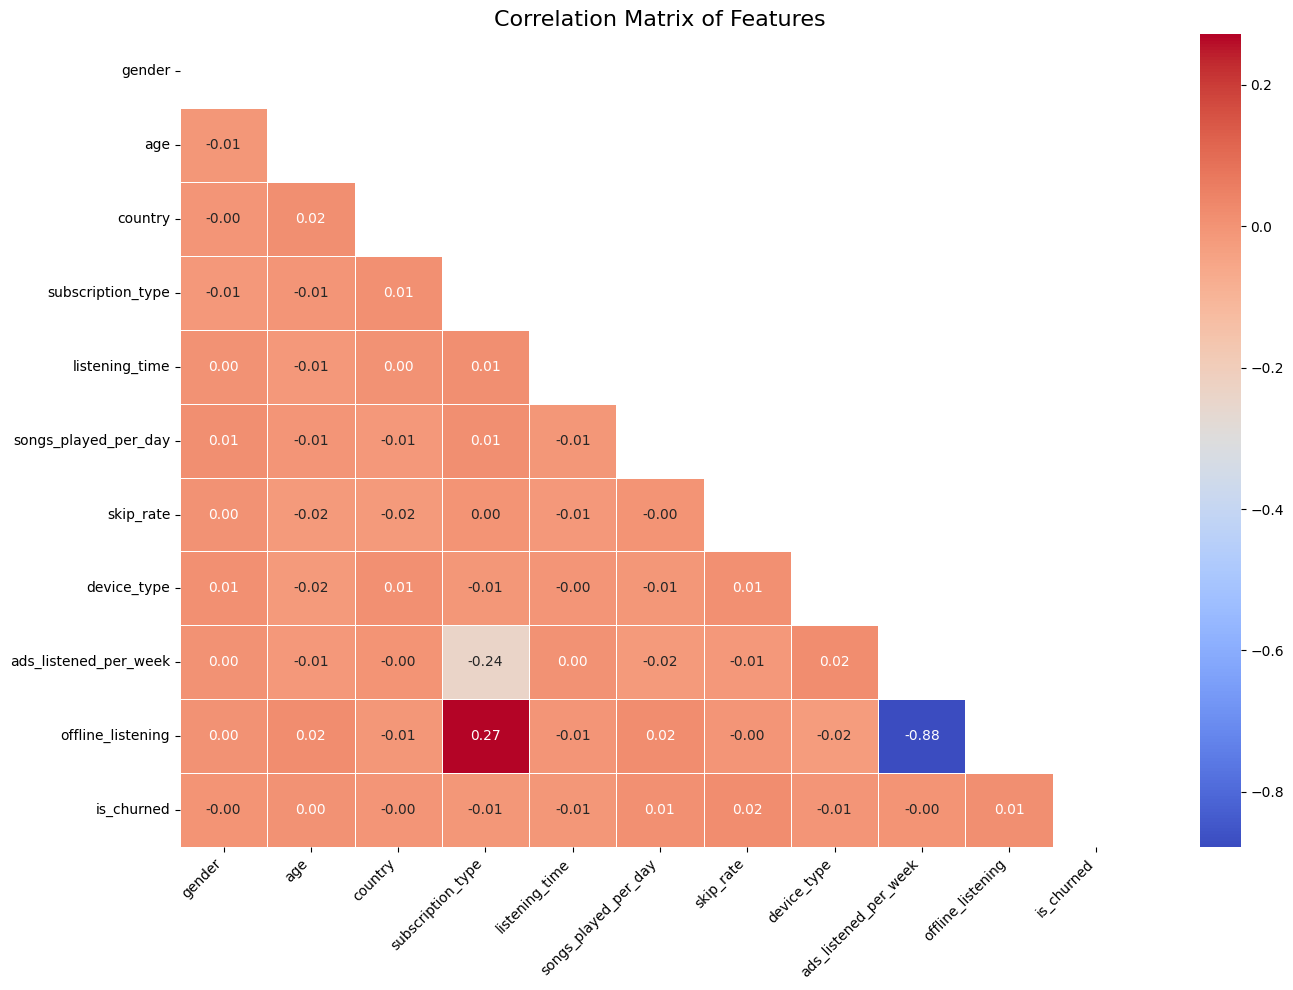

In [ ]:
df_corr = df.drop('user_id', axis=1)

categorical_cols = df_corr.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df_corr[col] = le.fit_transform(df_corr[col])

corr_matrix = df_corr.corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, linecolor='white')
plt.title('Correlation Matrix of Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Interpretation of Correlation Matrix**

- From above it is seen that there is a strong negative correlation between ads listened per week and offline listening on Spotify(-0.88). This is perfectly plausible according to some further insights obtained from Spotify's policy online which states that non-premium accounts(those that have adds) DO NOT have the ability to listen to music offline. This *stronger* correlation is also observed when comparing subscription type with offline listening - which is the only other stronger correlation in this chart.

- Below there will be further analysis onto which variables might be good predictors of churn. As of now, it is likely that offline listening might be dropped in order to prevent multicollineairity from happening. Note multicollinearity could offset  feature importance later when training the dataset in a Random Forest Model.

### EDA: Churn Checkup

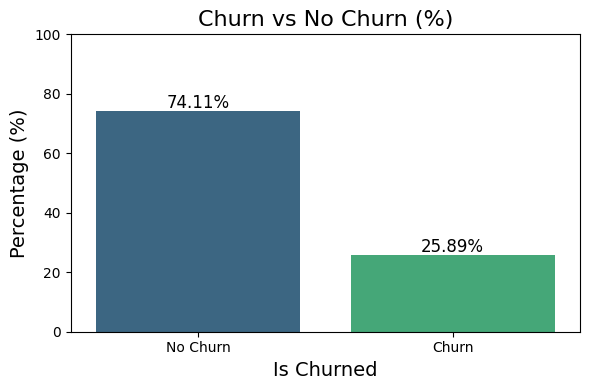

In [ ]:
plt.figure(figsize=(6, 4))
churn_counts = df['is_churned'].value_counts(normalize=True) * 100
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='viridis')
plt.title('Churn vs No Churn (%)', fontsize=16)
plt.xlabel('Is Churned', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['No Churn', 'Churn'])
plt.ylim(0, 100)
for i, v in enumerate(churn_counts.values):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

### EDA:  Continuous Feature Importance

In [ ]:

continuous_features = df.select_dtypes(include=np.number).columns.drop(['user_id', 'is_churned'])
X_continuous = df[continuous_features]
y = df['is_churned']

f_scores, p_values = f_classif(X_continuous, y)

anova_results = pd.DataFrame({
    'Feature': continuous_features,
    'F-Score': f_scores,
    'P-Value': p_values
})

anova_results = anova_results.sort_values(by='F-Score', ascending=False)

print("--- Continuous Feature Importance (ANOVA F-test) ---")
print(anova_results)

--- Continuous Feature Importance (ANOVA F-test) ---
                 Feature   F-Score   P-Value
3              skip_rate  2.079199  0.149358
5      offline_listening  1.301196  0.254029
2   songs_played_per_day  0.693882  0.404872
1         listening_time  0.464900  0.495363
0                    age  0.126790  0.721794
4  ads_listened_per_week  0.041556  0.838474


### EDA:  Categorical Feature Importance

In [ ]:

categorical_features = df.select_dtypes(include=['object']).columns

chi2_results = []

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['is_churned'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append({
        'Feature': feature,
        'Chi2-Statistic': chi2_stat,
        'P-Value': p_val
    })

chi2_df = pd.DataFrame(chi2_results)

chi2_df = chi2_df.sort_values(by='Chi2-Statistic', ascending=False)

print("\n--- Categorical Feature Importance (Chi-Squared Test) ---")
print(chi2_df)


--- Categorical Feature Importance (Chi-Squared Test) ---
             Feature  Chi2-Statistic   P-Value
1            country        5.956326  0.544858
2  subscription_type        4.457519  0.216111
3        device_type        2.371621  0.305498
0             gender        1.020116  0.600461


**Interpretation of EDA Feature Importance**

- After evaluating all, the correlation matrix, Chi-Suqared & ANOVA test for feature importance - it is seen that no feature is capable of predicting Churn with statistical significance(High P-Values).
- Moving on, it has been decided to drop the *ads_listened_per_week* because of its multicollinearity relationship with other variables and the potential effects this might have in offsetting feature importance moving forward.
- Also, because no variables seemed to clearly capture churn prediction on Spotify it might be more useful to select a model that is able to evaluate complex(non-linear) iterations between features such as XG Boost or Random Forest. I have selected XG Boost for predicting Churn.

### Implementing XG Boost

In [ ]:

y = df['is_churned']
X = df.drop(columns=['user_id', 'is_churned', 'ads_listened_per_week'])

X_processed = pd.get_dummies(X, columns=['gender', 'country', 'subscription_type', 'device_type'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

numerical_cols = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


final_xgb_model = XGBClassifier(
    subsample=0.9,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.01,
    gamma=0.1,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

final_xgb_model.fit(X_train, y_train)

y_pred = final_xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"--- Final Tuned XGBoost Model ---")
print(f"Accuracy on Test Set: {accuracy:.4f}\n")

--- Final Tuned XGBoost Model ---
Accuracy on Test Set: 0.7412



### PDP for Top Features

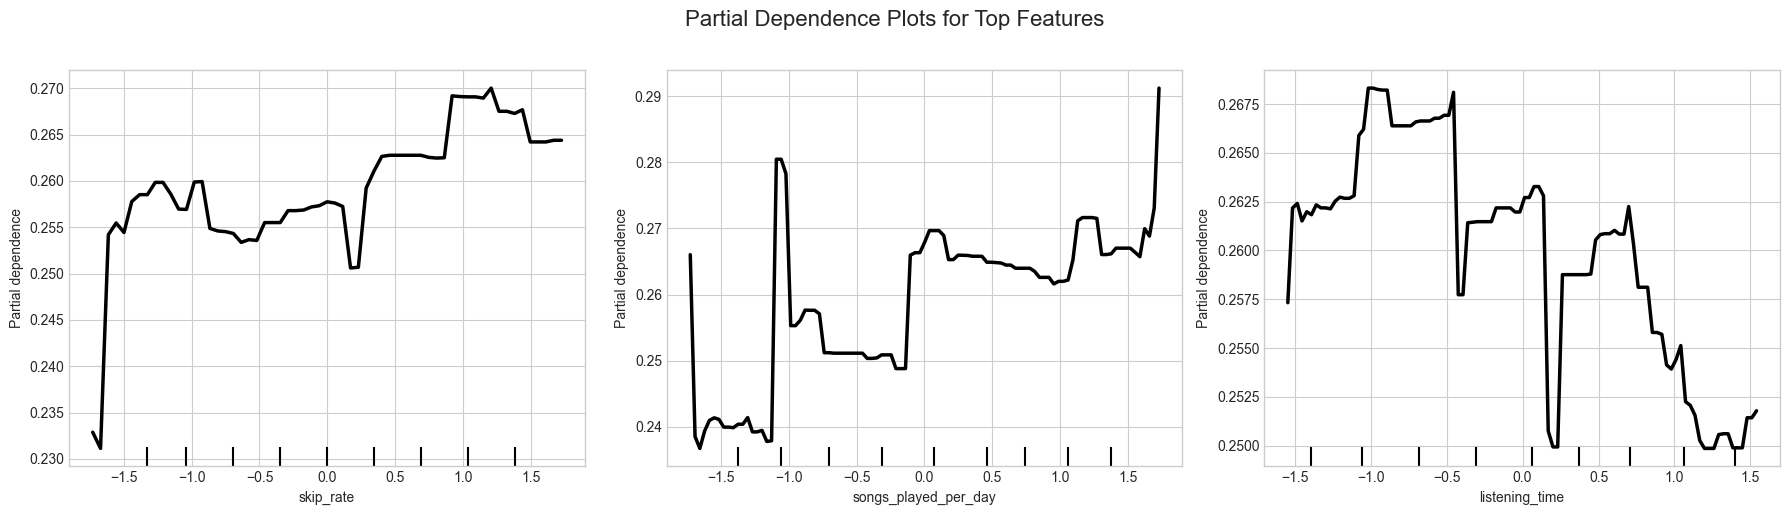

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
new_top_features = ['skip_rate', 'songs_played_per_day', 'listening_time']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Partial Dependence Plots for Top Features', fontsize=16, y=1.02)

for i, feature in enumerate(new_top_features):
    pdp_display = PartialDependenceDisplay.from_estimator(
        estimator=final_xgb_model,
        X=X_test,
        features=[feature],
        ax=axes[i],
        line_kw={"color": "black", "linewidth": 2.5}
    )
    sns.rugplot(x=X_test[feature], ax=axes[i], color='black', alpha=0.3)
    axes[i].set_xlabel(feature.replace("_", " ").title())
    axes[i].set_ylabel('Partial Dependence')
    axes[i].set_title('')

plt.tight_layout()
plt.show()

**Interpretation PDP**
- On average, the model predicts a higher probability of churn for users with higher skip rate - above skip rate of .75;
- On average, the model predicts a higher probability for those who play an extremely high number of songs played per day - above 1.5
- For listening time the effects seem more volatile and do not possess a clear pattern.


### ICE For Top Features

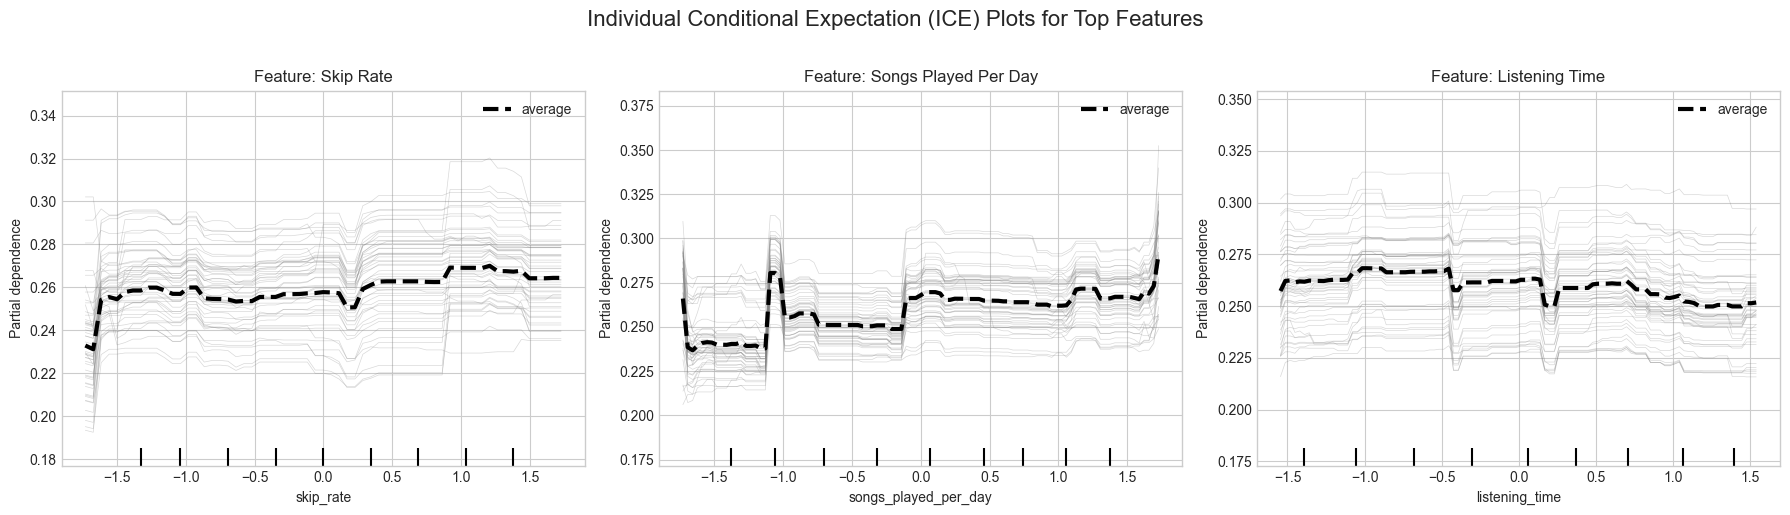

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Individual Conditional Expectation (ICE) Plots for Top Features', fontsize=16, y=1.02)

for i, feature in enumerate(new_top_features):
    ice_display = PartialDependenceDisplay.from_estimator(
        estimator=final_xgb_model,
        X=X_test,
        features=[feature],
        kind='both',
        subsample=50,
        ax=axes[i],
        pd_line_kw={"color": "black", "linewidth": 3, "alpha": 1.0, "linestyle": "--"},
        ice_lines_kw={"color": "gray", "alpha": 0.3, "linewidth": 0.5}
    )

    for line in axes[i].lines:
        if line.get_linestyle() == '--':
            line.set_label('average')

    sns.rugplot(x=X_test[feature], ax=axes[i], color='black', alpha=0.3)
    axes[i].set_xlabel(feature.replace("_", " ").title())
    axes[i].set_ylabel('ICE & Partial Dependence')
    axes[i].set_title(f'Feature: {feature.replace("_", " ").title()}', fontsize=12)
    axes[i].legend()

plt.tight_layout()
plt.show()

**ICE Interpretation**
- songs played per day and listening time show significant heterogeneous relationships. As the value changes the model clearly fluctuates. This might be attributed to potentially stronger interaction effects in the xgboost model between variables.
- skip rate appears more consistent across data points, as most  lines follow the general increasing trend without major fluctuations as the former two features.


### ALE for Top Features

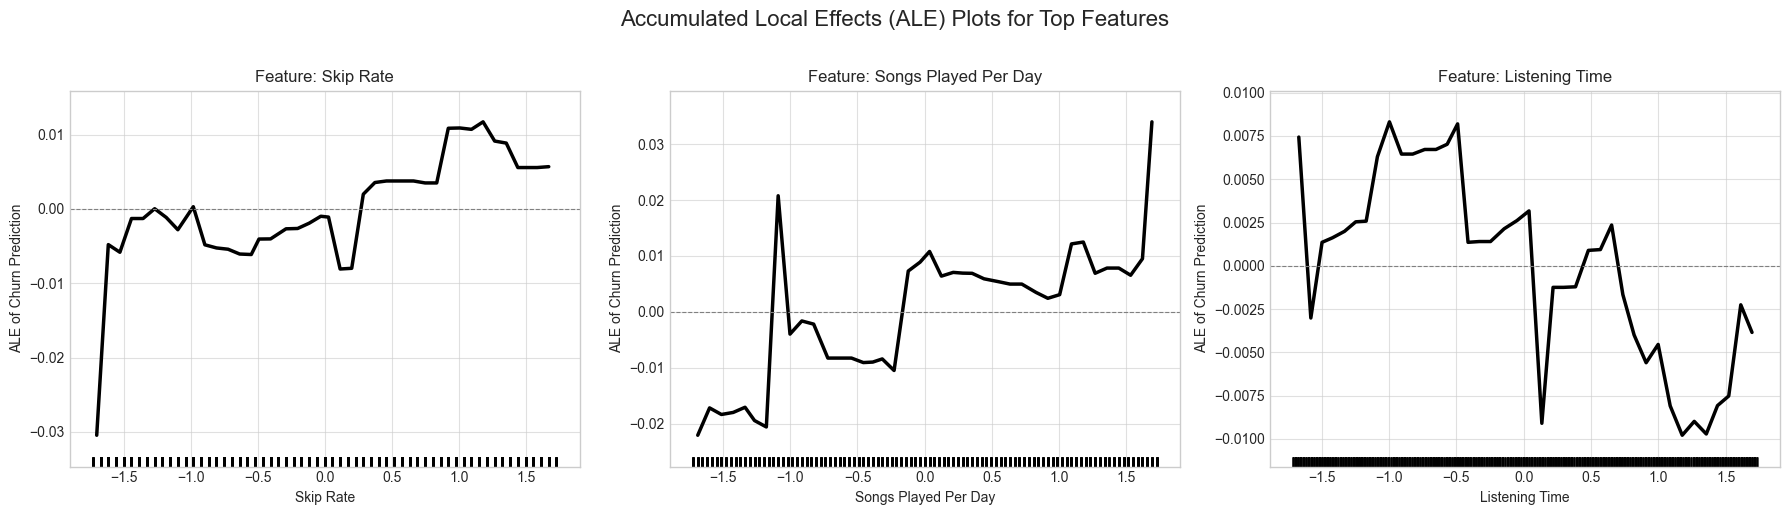

In [ ]:
# In[16]:
def plot_ale_styled(model, X_train_data, feature, ax, n_bins=40):
    bins = np.percentile(X_train_data[feature], np.linspace(0, 100, n_bins + 1))
    bins = np.unique(bins)

    X_binned = X_train_data.copy()
    X_binned['bin'] = pd.cut(X_train_data[feature], bins=bins, labels=False, include_lowest=True)

    local_effects = []
    bin_centers = []

    for i in range(len(bins) - 1):
        lower_bound, upper_bound = bins[i], bins[i+1]
        bin_centers.append((lower_bound + upper_bound) / 2)
        in_bin = X_binned[X_binned['bin'] == i]

        if len(in_bin) == 0:
            local_effects.append(0)
            continue

        X_lower = in_bin.copy()
        X_upper = in_bin.copy()
        X_lower[feature] = lower_bound
        X_upper[feature] = upper_bound

        pred_lower = model.predict_proba(X_lower.drop(columns='bin'))[:, 1]
        pred_upper = model.predict_proba(X_upper.drop(columns='bin'))[:, 1]

        avg_local_effect = np.mean(pred_upper - pred_lower)
        local_effects.append(avg_local_effect)

    ale = np.cumsum(local_effects)
    ale -= np.mean(ale)

    ax.plot(bin_centers, ale, color='black', linewidth=2.5)
    sns.rugplot(x=X_train_data[feature], ax=ax, color='black', alpha=0.3)
    ax.set_title(f'Feature: {feature.replace("_", " ").title()}', fontsize=12)
    ax.set_xlabel(f'{feature.replace("_", " ").title()}', fontsize=10)
    ax.set_ylabel('ALE of Churn Prediction', fontsize=10)
    ax.grid(True, linestyle='-', alpha=0.6)
    ax.axhline(0, color='gray', linewidth=0.8, linestyle='--')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Accumulated Local Effects (ALE) Plots for Top Features', fontsize=16, y=1.02)

for i, feature in enumerate(new_top_features):
    plot_ale_styled(final_xgb_model, X_train, feature, ax=axes[i])

plt.tight_layout()
plt.show()

**ALE Interpretation**
- When accumulating local effects, as Skip Rate and Songs Played per day Increase, it is seen churn probabilities also increase.
- at a moderate low listening time (-1.0 to -0.5), the churn increases most. This may correspond to potentially a period where users either become engaged or decide to leave the service.